In [20]:
import pandas as pd
import numpy as np

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
df=pd.read_excel('/content/drive/MyDrive/Data Science Projects/superstore_dataset/superstore_dataset.xls')

In [23]:
df.head(10)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,262,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",732,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,15,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,958,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,23,0.20,2.5164
5,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,49,0.00,14.1694
6,7,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,OFF-AR-10002833,Office Supplies,Art,Newell 322,8,0.00,1.9656
7,8,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,TEC-PH-10002275,Technology,Phones,Mitel 5320 IP Phone VoIP phone,908,0.20,90.7152
8,9,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,OFF-BI-10003910,Office Supplies,Binders,DXL Angle-View Binders with Locking Rings by S...,19,0.20,5.7825
9,10,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,California,90032,West,OFF-AP-10002892,Office Supplies,Appliances,Belkin F5C206VTEL 6 Outlet Surge,115,0.00,34.4700


#Data Preprocessing


In [24]:
df['Order Date'].dtype

dtype('<M8[ns]')

In [26]:
#only two columns needed.
df.drop(['Row ID', 'Order ID','Ship Date','Ship Mode','Customer ID','Customer Name','Segment','Country','City','State','Postal Code','Region','Product ID','Category','Sub-Category','Product Name','Discount','Profit'], axis = 1,inplace=True)
df

,Order Date,Sales
0,2016-11-08,262
1,2016-11-08,732
2,2016-06-12,15
3,2015-10-11,958
4,2015-10-11,23
...,...,...
9989,2014-01-21,26
9990,2017-02-26,92
9991,2017-02-26,259
9992,2017-02-26,30


In [27]:
df['Order Date']=pd.to_datetime(df['Order Date'])
df.set_index('Order Date',inplace=True)
df.head(10)

,Sales
Order Date,
2016-11-08,262
2016-11-08,732
2016-06-12,15
2015-10-11,958
2015-10-11,23
2014-06-09,49
2014-06-09,8
2014-06-09,908
2014-06-09,19


In [28]:
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

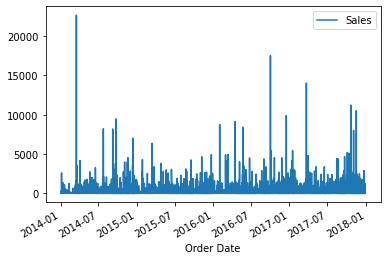

In [29]:
df.plot()

In [30]:
#Resampling the data Monthly frequency.
ts=df['Sales'].resample('MS').sum()

In [31]:
ts.head(10)

Order Date
2014-01-01    14266
2014-02-01     4537
2014-03-01    55757
2014-04-01    28349
2014-05-01    23697
2014-06-01    34653
2014-07-01    34000
2014-08-01    27973
2014-09-01    81878
2014-10-01    31514
Freq: MS, Name: Sales, dtype: int64

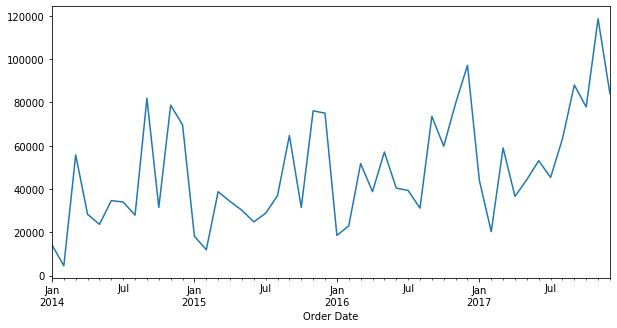

In [32]:
ts.plot(figsize=(10,5))

Checking stationarity with different ways.


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


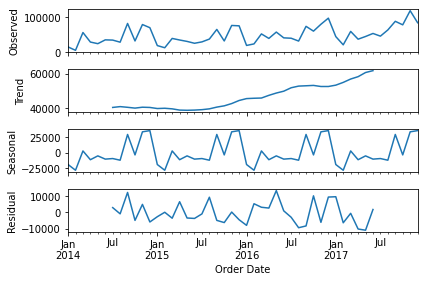

In [33]:
import statsmodels.api as sm
decomposition= sm.tsa.seasonal_decompose(ts, model='additive')
fig= decomposition.plot()
plt.show()

In [34]:
# checking stationarity with adfuller test
from statsmodels.tsa.stattools import adfuller

In [35]:
test_result=adfuller(ts.dropna())

In [36]:
#H0- It is Non stationary
#H1- It is Stationary
#printing result of adfuller test
labels= ['ADF Test statistics', 'P-Value','no. of Lags used', 'No. of Observation used']
for value, label in zip(test_result,labels):
    print(label+ ':'+ str(value))
if test_result[1] <= 0.05:
    print('Strong evidence against H0. Rejecting the Null Hypothesis. Data is stationary')
else: 
    print('Weak Evidence against H0. Accepting the Null Hypothesis. Data is stationary')

ADF Test statistics:-4.491931424802364
P-Value:0.00020334750350207417
no. of Lags used:0
No. of Observation used:47
Strong evidence against H0. Rejecting the Null Hypothesis. Data is stationary


checking with Rolling statistics

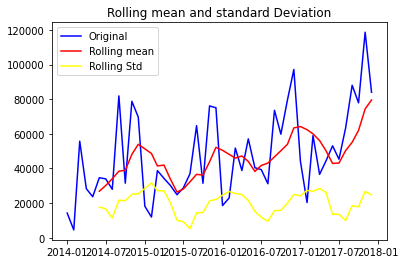

In [37]:
#determining Rolling statistics
rolling_mean= ts.rolling(6).mean()
rolling_std= ts.rolling(6).std()

#plotting rolling statistics
original= plt.plot(ts, color='Blue', label='Original')
mean= plt.plot(rolling_mean, color='Red', label='Rolling mean')
original= plt.plot(rolling_std, color='yellow', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling mean and standard Deviation')
plt.show(block=False)


In [38]:
len(ts)

48

In [39]:
train=ts[:36]
test=ts[36:]

In [40]:
#Building ARIMA Model
# HyperParameters of ARIMA Model p=6 d=0 q=1
from statsmodels.tsa.arima_model import ARIMA

In [41]:
import warnings
warnings.filterwarnings('ignore')
model= ARIMA(train, order=(6,0,1)).fit()

In [42]:
#Predicting on Test dataset


In [43]:
pred= model.predict(start=len(train),end=(len(ts)-1))
pred.head(10)

2017-01-01    43623.535300
2017-02-01    50619.361388
2017-03-01    47775.110614
2017-04-01    33187.390355
2017-05-01    44986.768463
2017-06-01    54476.391553
2017-07-01    39484.758811
2017-08-01    53816.111894
2017-09-01    47715.239243
2017-10-01    44334.731050
Freq: MS, dtype: float64

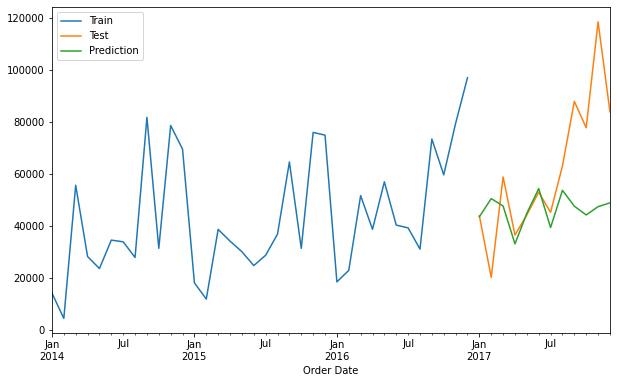

In [44]:
#Model Evaluation
from sklearn.metrics import mean_squared_error
train.plot(legend=True, label='Train', figsize=(10,6))
test.plot(legend=True, label='Test')
pred.plot(legend=True, label='Prediction')

#As it's a seasonal data, Only ARIMA is not working that well. so we can use SARIMAX to increase accuracy in forecasting.

In [45]:
import statsmodels.api as sm

In [46]:
model1= sm.tsa.statespace.SARIMAX(ts, order=(6,0,1), seasonal_order=(6,0,1,6))
result1= model1.fit()

In [47]:
pred1= result1.predict(start=len(train),end=(len(ts)-1),dynamic=True)
pred1.head(10)

Order Date
2017-01-01    43771.482982
2017-02-01    37723.556187
2017-03-01    62175.832361
2017-04-01    44429.706837
2017-05-01    56007.377141
2017-06-01    48540.398704
2017-07-01    42734.109228
2017-08-01    40709.886672
2017-09-01    71919.827614
2017-10-01    55779.223100
Freq: MS, dtype: float64

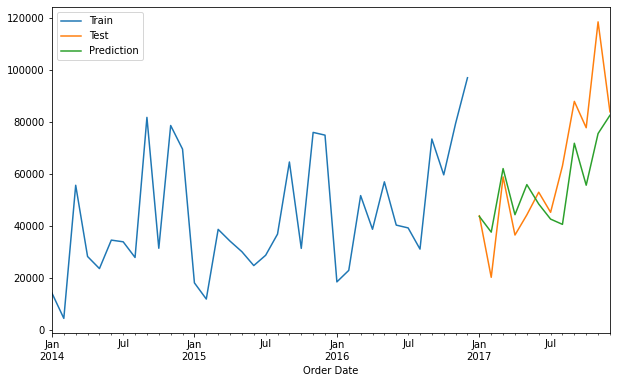

In [48]:
#Model Evaluation
from sklearn.metrics import mean_squared_error
train.plot(legend=True, label='Train', figsize=(10,6))
test.plot(legend=True, label='Test')
pred1.plot(legend=True, label='Prediction')

#Future demand forecasting for upcoming months

In [49]:
from pandas.tseries.offsets import DateOffset
future_months=[ts.index[-1]+ DateOffset(months=x)for x in range(0,24)]

In [50]:
ts.tail(10)

Order Date
2017-03-01     58966
2017-04-01     36605
2017-05-01     44361
2017-06-01     53087
2017-07-01     45347
2017-08-01     63213
2017-09-01     88040
2017-10-01     77891
2017-11-01    118631
2017-12-01     84014
Freq: MS, Name: Sales, dtype: int64

In [51]:
ts.head(10)

Order Date
2014-01-01    14266
2014-02-01     4537
2014-03-01    55757
2014-04-01    28349
2014-05-01    23697
2014-06-01    34653
2014-07-01    34000
2014-08-01    27973
2014-09-01    81878
2014-10-01    31514
Freq: MS, Name: Sales, dtype: int64

In [53]:
future_months_df=pd.DataFrame(index=future_months[1:])
future_months_df.head(24)

""
2018-01-01
2018-02-01
2018-03-01
2018-04-01
2018-05-01
2018-06-01
2018-07-01
2018-08-01
2018-09-01
2018-10-01


In [54]:
ts.to_frame()

,Sales
Order Date,
2014-01-01,14266
2014-02-01,4537
2014-03-01,55757
2014-04-01,28349
2014-05-01,23697
2014-06-01,34653
2014-07-01,34000
2014-08-01,27973
2014-09-01,81878


In [ ]:
#future_months_series=future_months_df.iloc[:]

In [55]:
dataset=pd.concat([ts,future_months_df])

In [56]:
dataset.head(10)

,0
2014-01-01,14266.0
2014-02-01,4537.0
2014-03-01,55757.0
2014-04-01,28349.0
2014-05-01,23697.0
2014-06-01,34653.0
2014-07-01,34000.0
2014-08-01,27973.0
2014-09-01,81878.0
2014-10-01,31514.0


In [57]:
dataset.tail(10)

,0
2019-02-01,NaN
2019-03-01,NaN
2019-04-01,NaN
2019-05-01,NaN
2019-06-01,NaN
2019-07-01,NaN
2019-08-01,NaN
2019-09-01,NaN
2019-10-01,NaN
2019-11-01,NaN


In [58]:
dataset = dataset.rename(columns={dataset.columns[0]: 'Sales'})

In [59]:
dataset['Demand_Forecast']= result1.predict(start=len(ts),end= (len(dataset)-1), dynamic=True)

In [64]:
dataset.head(5)

,Sales,Demand_Forecast
2014-01-01,14266.0,NaN
2014-02-01,4537.0,NaN
2014-03-01,55757.0,NaN
2014-04-01,28349.0,NaN
2014-05-01,23697.0,NaN


In [61]:
dataset.tail(5)

,Sales,Demand_Forecast
2019-07-01,NaN,52317.181155
2019-08-01,NaN,56630.754373
2019-09-01,NaN,74777.048733
2019-10-01,NaN,65604.986894
2019-11-01,NaN,86314.773825


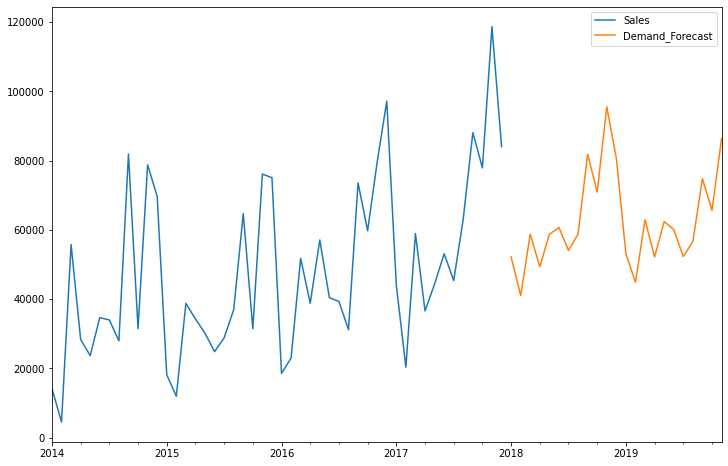

In [62]:
dataset[['Sales','Demand_Forecast']].plot(figsize=(12,8))

In [63]:
dataset.tail(24)

,Sales,Demand_Forecast
2017-12-01,84014.0,NaN
2018-01-01,NaN,52172.899641
2018-02-01,NaN,40999.965372
2018-03-01,NaN,58752.642854
2018-04-01,NaN,49317.620768
2018-05-01,NaN,58728.032468
2018-06-01,NaN,60681.758398
2018-07-01,NaN,54049.481811
2018-08-01,NaN,58794.191866
2018-09-01,NaN,81814.180444


Checking perfect Hyperparamater values i.e. for P, d and q values

In [ ]:
#using custom for loop for getting hyperparameter values
import itertools
p=range(0,7)
q=range(0,7)
d=range(0,2)


In [ ]:
pdq= list(itertools.product(p,d,q))

In [ ]:
len(pdq)

98

In [ ]:
rmse=[]
order=[]
for pdq in pdq:
  try:
    model=ARIMA(train, order=pdq).fit()
    pred=model.predict(start=len(train),end=(len(ts)-1))
    error=np.sqrt(mean_squared_error(test,pred))
    order.append(pdq)
    rmse.append(error)
  except:
    continue

In [ ]:
result=pd.DataFrame(list(zip(order, rmse)),columns =['pdq', 'RMSE'])
result.to_csv('C:\\Users\\Administrator\\Desktop\\arima_result.csv')

In [ ]:
result[result['RMSE']==result['RMSE'].min()]

,pdq,RMSE
39,"(6, 0, 1)",29115.829946
